# Model training and selection

In [1]:
import pickle
from tqdm.notebook import tqdm
import numpy as np
import random

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn

import time

In [2]:
name = "testing_set"

with open(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/datasets/{name}.obj", 'rb') as f:
    data_set = pickle.load(f)

In [3]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [4]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init():
  global net, loss_function, scheduler, optimizer
  
  net = torchvision.models.resnet18(pretrained=True).to(device)

  #net = torchvision.models.densenet121(pretrained=True).to(device)
      
  for param in net.parameters():
      param.requires_grad = False   # Freezing the convolutional layers
      
  net.fc = nn.Sequential(
                nn.Linear(512, 128), #512
                nn.ReLU(inplace=True),
                nn.Linear(128, 2),
                nn.Softmax(dim = -1)
                ).to(device)

  net.fc.apply(init_weights) # Xavier init

  # resnet.fc = torch.load("") # Model loading

  print("Number of free parameters on fc layer: ", sum(p.numel() for p in net.fc.parameters()))

  #Hyperparameters:
  learning_rate = 0.001 # LR
  loss_function = nn.BCELoss()
  # Loss # [1,0] es positivo y [0,1] negativo # weight = torch.tensor([(495+201)/(2*495), (201+495)/(2*201)]).to(device)) # El negativo cuesta 2.5... mas
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)# Optimizer
  lambda1 = lambda epoch: 0.8 ** epoch # Scheduler
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

init()

Number of free parameters on fc layer:  65922


In [5]:
def fwd_pass(X, y, train=False):
# IMPORTANTE, TRAIN = FALSE PARA QUE NO ENTRENE CON EL TEST DATA ESTO ES PARA PODER HACER TEST MIENTRAS ENTRENO Y VALIDO, 
# SE ESPERA QUE LA EXACTITUD EN EL TEST DE VALIDACIÓN SEA MENOR
    if train: 
        net.zero_grad()

    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    del outputs

    return acc, loss


In [6]:
def validate(val_X, val_y, size=32):
# Hago un test con datos en una región aleatoria para que la distribución sea mejor
  val_X, val_y = shuffle(val_X, val_y) 
  
  if size > 0.7*len(val_y):
    ramdom_start = 0
  else:
    ramdom_start = np.random.randint(len(val_X)-size)

  X, y = val_X[ramdom_start:ramdom_start+size].to(device), val_y[ramdom_start:ramdom_start+size].to(device)
  val_acc, val_loss = fwd_pass(X.view(-1, 3, SIZE_X, SIZE_Y), y, train=False)
  del X, y

  return val_acc, val_loss # accuracy y loss en validation set

In [7]:
def test():
# Hago un test con datos en una región aleatoria para que la distribución sea mejor
  X, y = test_X.to(device), test_y.to(device)
  test_acc, test_loss = fwd_pass(X.view(-1, 3, SIZE_X, SIZE_Y), y)
  del X, y

  return test_acc, test_loss # accuracy y loss en test set

In [8]:
def shuffle(X, y): # Esta función debería hacer un shuffle del data set sin desordenar las etiquetas
  c = list(zip(X, y))
  random.shuffle(c)
  X, y = zip(*c)
  return torch.stack(X), torch.stack(y)

In [9]:
%%time

patch_size = 300

SIZE_X = patch_size
SIZE_Y = patch_size

MODE = "a"
MODEL_NAME = "ejemplo"

def train():

  global net, loss_function, scheduler, optimizer, train_X, train_y

  print(MODEL_NAME)
  BATCH_SIZE = 16
  EPOCHS = 35

  N_BATCHES = len(range(0, len(train_X), BATCH_SIZE))
  N_BATCHES_VAL = len(range(0, len(val_X), BATCH_SIZE))
  
  with open("C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss = 0, 0
      val_acc, val_loss = 0, 0

      train_X, train_y = shuffle(train_X, train_y)

      print("\nEPOCH: ", epoch+1)

      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,3,SIZE_X,SIZE_Y).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)
        
        net.train() # Making sure that the model is in training mode
        
        acc_aux, loss_aux = fwd_pass(batch_X, batch_y, train=True)
        
        acc += acc_aux/N_BATCHES # Calculating the average loss and acc trough batches
        loss += loss_aux/N_BATCHES
        
        del batch_X, batch_y

      for i in tqdm(range(0, int(len(val_X)*0.2), BATCH_SIZE)):
        net.eval() # Making sure that the model is not training and deactivate droptout
        
        val_acc_aux, val_loss_aux = validate(val_X, val_y, size=BATCH_SIZE)
      
        val_acc += val_acc_aux/N_BATCHES_VAL # Calculating the average loss and acc trough batches
        val_loss += val_loss_aux/N_BATCHES_VAL

      print("Val loss: ", val_loss.item()," Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc," Train acc: ", acc, "\n")

      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{round(float(val_acc),3)},{round(float(val_loss),4)}\n")
      f.write("\n\n")

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

    torch.save(net.fc, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")


CPU times: total: 0 ns
Wall time: 0 ns


In [10]:
X, y = shuffle(data_set.inputs.float(), data_set.labels.float())

frac = int(0.2*len(y))

train_X, train_y = X[frac:], y[frac:]

val_X, val_y = X[:frac], y[:frac]

train()

ejemplo

EPOCH:  1


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.1578691005706787  Train loss:  0.16842524707317352 

Val acc:  0.9407894736842097  Train acc:  0.9414370078740125 

Learning Rate:  0.001

EPOCH:  2


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.09161033481359482  Train loss:  0.09915363043546677 

Val acc:  0.964473684210526  Train acc:  0.9645669291338543 

Learning Rate:  0.0008

EPOCH:  3


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.07041428238153458  Train loss:  0.09802714735269547 

Val acc:  0.978947368421053  Train acc:  0.9630905511810979 

Learning Rate:  0.0006400000000000002

EPOCH:  4


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.0669717788696289  Train loss:  0.07974271476268768 

Val acc:  0.974342105263158  Train acc:  0.9711286089238811 

Learning Rate:  0.0005120000000000001

EPOCH:  5


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.0856744647026062  Train loss:  0.08902439475059509 

Val acc:  0.9690789473684206  Train acc:  0.9693241469816233 

Learning Rate:  0.0004096000000000001

EPOCH:  6


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.06483880430459976  Train loss:  0.07858539372682571 

Val acc:  0.9749999999999996  Train acc:  0.9701443569553765 

Learning Rate:  0.0003276800000000001

EPOCH:  7


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.0782945305109024  Train loss:  0.06877914816141129 

Val acc:  0.9756578947368421  Train acc:  0.9757217847768984 

Learning Rate:  0.0002621440000000001

EPOCH:  8


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.08649200946092606  Train loss:  0.0633341521024704 

Val acc:  0.9703947368421054  Train acc:  0.9790026246719119 

Learning Rate:  0.0002097152000000001

EPOCH:  9


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.07527042925357819  Train loss:  0.06252022087574005 

Val acc:  0.9743421052631576  Train acc:  0.9785104986876596 

Learning Rate:  0.0001677721600000001

EPOCH:  10


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.07373607903718948  Train loss:  0.06071171537041664 

Val acc:  0.9657894736842106  Train acc:  0.9770341207349041 

Learning Rate:  0.00013421772800000008

EPOCH:  11


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.0811421275138855  Train loss:  0.05225608870387077 

Val acc:  0.9763157894736844  Train acc:  0.9780183727034079 

Learning Rate:  0.00010737418240000006

EPOCH:  12


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.077543705701828  Train loss:  0.054468076676130295 

Val acc:  0.9743421052631577  Train acc:  0.9804790026246675 

Learning Rate:  8.589934592000005e-05

EPOCH:  13


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.08255679905414581  Train loss:  0.05480021983385086 

Val acc:  0.9690789473684209  Train acc:  0.9811351706036698 

Learning Rate:  6.871947673600005e-05

EPOCH:  14


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.08448676019906998  Train loss:  0.07328007370233536 

Val acc:  0.9717105263157894  Train acc:  0.9753937007873971 

Learning Rate:  5.497558138880004e-05

EPOCH:  15


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.07675354927778244  Train loss:  0.05141597241163254 

Val acc:  0.9730263157894736  Train acc:  0.9816272965879222 

Learning Rate:  4.398046511104004e-05

EPOCH:  16


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.04775453358888626  Train loss:  0.05557244271039963 

Val acc:  0.9848684210526318  Train acc:  0.9801509186351661 

Learning Rate:  3.518437208883203e-05

EPOCH:  17


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.07451549172401428  Train loss:  0.05212770402431488 

Val acc:  0.9723684210526313  Train acc:  0.9814632545931713 

Learning Rate:  2.8147497671065623e-05

EPOCH:  18


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.06972746551036835  Train loss:  0.045688875019550323 

Val acc:  0.9802631578947371  Train acc:  0.9839238845144311 

Learning Rate:  2.2517998136852502e-05

EPOCH:  19


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.06899280101060867  Train loss:  0.04582453891634941 

Val acc:  0.9749999999999998  Train acc:  0.9819553805774234 

Learning Rate:  1.8014398509482003e-05

EPOCH:  20


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.057333000004291534  Train loss:  0.06193853169679642 

Val acc:  0.9796052631578953  Train acc:  0.9812992125984202 

Learning Rate:  1.4411518807585603e-05

EPOCH:  21


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.06379739940166473  Train loss:  0.04825754836201668 

Val acc:  0.9802631578947373  Train acc:  0.9845800524934334 

Learning Rate:  1.1529215046068483e-05

EPOCH:  22


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.061200883239507675  Train loss:  0.06522289663553238 

Val acc:  0.9782894736842103  Train acc:  0.9794947506561634 

Learning Rate:  9.223372036854787e-06

EPOCH:  23


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.06676815450191498  Train loss:  0.04683670401573181 

Val acc:  0.9723684210526314  Train acc:  0.9839238845144312 

Learning Rate:  7.37869762948383e-06

EPOCH:  24


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.04779176414012909  Train loss:  0.049511753022670746 

Val acc:  0.9848684210526317  Train acc:  0.9824475065616753 

Learning Rate:  5.902958103587064e-06

EPOCH:  25


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.06760656088590622  Train loss:  0.04884065315127373 

Val acc:  0.9763157894736844  Train acc:  0.9822834645669245 

Learning Rate:  4.722366482869652e-06

EPOCH:  26


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.07730134576559067  Train loss:  0.0514582134783268 

Val acc:  0.9736842105263162  Train acc:  0.9814632545931714 

Learning Rate:  3.7778931862957216e-06

EPOCH:  27


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.052726227790117264  Train loss:  0.049368586391210556 

Val acc:  0.9835526315789476  Train acc:  0.9824475065616751 

Learning Rate:  3.0223145490365774e-06

EPOCH:  28


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.0666743814945221  Train loss:  0.04847974330186844 

Val acc:  0.975657894736842  Train acc:  0.9831036745406772 

Learning Rate:  2.417851639229262e-06

EPOCH:  29


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.06653952598571777  Train loss:  0.04628095030784607 

Val acc:  0.9769736842105262  Train acc:  0.9829396325459272 

Learning Rate:  1.93428131138341e-06

EPOCH:  30


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.06211774796247482  Train loss:  0.050958678126335144 

Val acc:  0.9782894736842106  Train acc:  0.9811351706036703 

Learning Rate:  1.547425049106728e-06

EPOCH:  31


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.06436581909656525  Train loss:  0.04849790409207344 

Val acc:  0.9756578947368422  Train acc:  0.9821194225721739 

Learning Rate:  1.2379400392853823e-06

EPOCH:  32


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.0690905973315239  Train loss:  0.04820462688803673 

Val acc:  0.9743421052631578  Train acc:  0.9842519685039323 

Learning Rate:  9.903520314283058e-07

EPOCH:  33


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.057462405413389206  Train loss:  0.048607390373945236 

Val acc:  0.974342105263158  Train acc:  0.982283464566924 

Learning Rate:  7.922816251426449e-07

EPOCH:  34


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.07440144568681717  Train loss:  0.049571678042411804 

Val acc:  0.9763157894736844  Train acc:  0.981627296587922 

Learning Rate:  6.338253001141158e-07

EPOCH:  35


  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Val loss:  0.05093497782945633  Train loss:  0.046587955206632614 

Val acc:  0.9848684210526317  Train acc:  0.9844160104986829 

Learning Rate:  5.070602400912927e-07


In [20]:
def learning_curve():
  fig, axs = plt.subplots(2, figsize = (7,6))

  acc_df = pd.read_csv("C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model.log")
  acc_df.columns = ["MODEL_NAME", "TIME", "ACC", "LOSS", "VAL_ACC", "VAL_LOSS"]

  fig, axs = plt.subplots(2, figsize=(5,7))
  #ax = plt.gca() # GET CURRENT AXIS

  axs[0].legend("MODEL_NAME", loc=2)

  acc_df.plot(y="ACC", ax=axs[0])
  acc_df.plot(y="VAL_ACC", ax=axs[0])

  acc_df.plot(y="LOSS", ax=axs[1])
  acc_df.plot(y="VAL_LOSS",ax=axs[1])

  fig.show()
  fig.savefig(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\lc\\l_curve_{MODEL_NAME}.pdf")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_10156\440877980.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


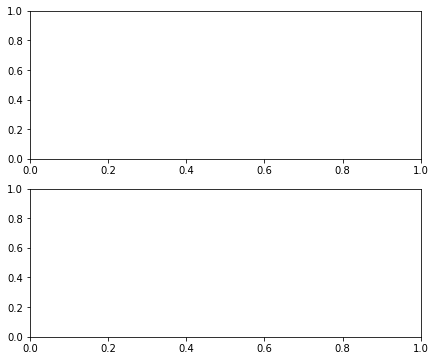

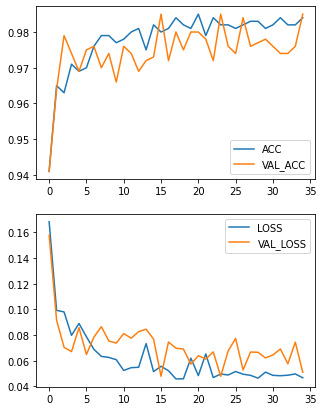

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

learning_curve()